# 06. RNN

本演習ではRNN系統のモデルを用いて、自然言語データを解析・分類してみましょう。<br>
取り扱うトピックは以下の通りです。
- 勾配クリッピング（TensorFlow）
- RNN（スクラッチ）
- LSTM（スクラッチ）
- GRU（スクラッチ）
- 双方向LSTM（TensorFlow）

所要時間：<font color="Red">5~8時間</font>

### 【Google colabのみ実行】ライブラリのインストール

必要なライブラリのインストールと、実行環境のバージョンを統一します。<br>

使用するライブラリ名とバージョンは配布資料の<font color=Red>「requirements.txt」</font>で確認できます。

※以下のセルを実行しましたら、「ランタイム」→「ランタイムを再起動」により<font color=Red>再起動</font>を行ってください。

In [1]:
import sys
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # ライブラリのインストール
    !pip install tensorflow==2.8.0 gensim==4.1.2 nltk==3.6.5
else:
    print("Not Google Colab")

Not Google Colab


## ライブラリのインポート

まずは必要なライブラリをインポートしましょう。<br>
gensim:自然言語処理モデルを呼び出せるライブラリ<br>
sklearn:機械学習用<br>

In [2]:
import gensim
import numpy as np
import os,pickle
import matplotlib.pyplot as plt
from gensim.models import word2vec
import gensim.downloader as api
from sklearn.model_selection import train_test_split
# 乱数シードを指定
np.random.seed(seed=0) 

## データセットの用意

今回はデータセットとして"Large Movie Review dataset"を用います。<br>
"Large Movie Review dataset"（以下IMDb）は大規模な映画レビューのデータで、映画レビューコメントが「ポジティブか／ネガティブか」の感情を判別するために使う、感情分析用データセット（＝構造化データセット）です。<br>

IMDbデータセットは、主に二値分類（つまり「ポジティブか／ネガティブか」の判別）を目的としたディープラーニング／機械学習の研究や初心者向けチュートリアルで使われています。<br>

データセット全体は2万5000件の訓練データ（テキストとラベル）と2万5000件のテストデータ（テキストとラベル）の合計5万件で構成されます（※「ラベル」＝正解を示す教師データ）。<br>
また、教師あり学習用に「ポジティブか／ネガティブか」というラベル付けが既に行われています。

In [3]:
def load_movie_reviews():
    from nltk.corpus import movie_reviews
    try:
        movie_reviews.categories()
    except:
        import nltk
        nltk.download('movie_reviews')
        from nltk.corpus import movie_reviews
    raw_data = []
    for category in movie_reviews.categories():
        if category == 'pos':
            label = '1'
        elif category == 'neg':
            label = '0'

        for fileid in movie_reviews.fileids(category):
            review_words = list(movie_reviews.words(fileid))
            if len(review_words) >= 400:
                review_words = review_words[:400]
            else:
                review_words.extend([" " for i in range(400 - len(review_words))])
            review_dictionary = {
                'text': review_words,
                'label': label
            }
            raw_data.append(review_dictionary)
    return raw_data 

今回は読み込んだデータを"data.pkl"という名前でローカルPCに保存する。

In [4]:
if os.path.exists("data.pkl"):
    f = open("data.pkl", "rb")
    data = pickle.load(f)
    f.close()
else:
    data = load_movie_reviews()
    f = open("data.pkl", "wb")
    pickle.dump(data,f)
    f.close()

In [5]:
print("要素数", len(data))
print("データ型", type(data))

要素数 2000
データ型 <class 'list'>


In [6]:
data_label = data[0]['label']
print(data_label)

0


## 勾配クリッピング（TensorFlow）

勾配クリッピングは、誤差逆伝播の実行時に勾配の上限を定めることで、勾配爆発を抑制する手法です。<br>

勾配ベクトル$\Delta\omega^{(t)}$のノルムが上限値$g$以上になったとき、下記の式によってパラメータ更新の大きさを調整します。

$$
\Delta\omega^{(t)}=\frac{g}{||\Delta\omega^{(t)}||}\Delta\omega^{(t)}
$$

まずはこの処理を関数で実装しましょう。<br>

```
【TensorFlow関数の説明】
  TensorFlow.norm(input, axis): テンソルinputのaxis軸に対して行列ノルムまたはベクトルノルムを算出する
```

### 問1. 勾配クリッピング関数
* <font color="Red">問1. 勾配クリッピングの処理を関数で実装してください。</font><br>
  * <font color="Red">問1-1. 勾配の値 **grads_norm** が上限値 **threshold** 以上になった場合にのみ処理が行われます。まずはこの条件をif文で記述しましょう。</font><br>
  * <font color="Red">問1-2. 勾配が閾値以上の場合に、上限値 **threshold** に抑制する処理をTensorFlowで記述しましょう。</font><br>

【補足】『ゼロから作るDeep Learning』2のp.233

In [7]:
import tensorflow as tf
a = tf.constant([-1.3, 0.7, -0.3, 1.0, 0.9])
a.numpy()

array([-1.3,  0.7, -0.3,  1. ,  0.9], dtype=float32)

In [8]:
grads_norm = tf.norm(a)
grads_norm.numpy()

2.019901

In [9]:
import tensorflow as tf

def gradient_clip(grads, threshold):
    num_grads = len(grads)
    grads_norm = tf.norm(grads, axis=1)
    
    for i in range(num_grads):
        if grads_norm[i] >= threshold:### 問1-1 ###
            grads[i] = grads[i] * threshold / (grads_norm[i] + 1e-6)### 問1-2 ###
    
    return grads

この関数を実際のテンソルに適用すると、以下のようになる。

In [10]:
# 閾値を超えるテンソル
a = np.array(
    [[ -1.3980,   0.7115,  -0.3282,   1.0304,   0.9501],
     [  2.0440, -13.4030,  -3.1160,   0.5170,   2.9810],
     [ -1.3672,  -1.3978,   0.8901,   2.4695,   0.1738]]
)

threshold = 2.
b = gradient_clip(a, threshold)
print(b)

[[-1.31327395  0.66837941 -0.30830938  0.96795242  0.89251901]
 [ 0.28714672 -1.88289014 -0.43774421  0.07262958  0.41877904]
 [-0.83421694 -0.85288798  0.54310745  1.5068013   0.1060466 ]]


## 基本的な関数の定義

次に、基本的な関数として、Affineクラス、SGD、Adam、活性化関数、損失関数、勾配クリッピング関数を定義します。<br>
詳細は前章までで説明しているので、復習として見てください。

Affineクラス

In [11]:
# Affineクラス
class Affine:
    def __init__(self, W, b):
        self.params,self.grads,self.x = [W, b],[np.zeros_like(W), np.zeros_like(b)],None

    def forward(self, x):
        N, D = x.shape
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        x = self.x
        N, D = x.shape
        W, b = self.params
        db = np.sum(dout, axis=0)
        dW = np.dot(x.T, dout)
        dx = np.dot(dout, W.T)
        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx

SGD/Adam

In [12]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr        
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]
            
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr,self.iter = lr,0
        self.beta1,self.beta2 = beta1,beta2
        self.m,self.v = None,None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)
        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

活性化関数と損失関数


In [13]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))
    return x

In [14]:
class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss,self.y,self.t = None,None,None
        
    def forward(self, x, t):
        self.t = t
        x = x.flatten()
        self.y = sigmoid(x)
        self.loss = -np.mean(np.log(self.y + 1e-7) * t + np.log(1 - self.y + 1e-7) * (1 - t))
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t)/batch_size
        dx = dx.reshape(-1,1)
        return dx

勾配クリッピング関数（Tensorflowを使わないバージョン。こちらも理解しておきましょう）

In [15]:
def clip_grads(grads, threshold):
    num_grads = len(grads)
    grads_norm = np.sqrt(np.sum(grads**2, axis=1))
    
    for i in range(num_grads):
        if grads_norm[i] >= threshold:
            grads[i] = grads[i] / (grads_norm[i] + 1e-6) * threshold
    
    return grads

## Embedderの用意

学習時には単語ID列の変換先となる単語ベクトルの取得が必要になる。<br>
本来はこの作業にもディープラーニングモデルによる学習が必要になるのだが、莫大な計算コストがかかる。

そこで今回は、gensimのライブラリから呼び出せる学習済みモデル"glove-twitter-25"を使用する。

In [16]:
from gensim.models import KeyedVectors
if os.path.exists("embedder.model"):
    model = KeyedVectors.load_word2vec_format("embedder.model")
else:
    model = api.load("glove-twitter-25")
    model.save_word2vec_format("embedder.model")

モデルに単語を与えると対応する単語ベクトルを返して、単語が存在しない場合は0ベクトルを返すように関数を設定する。

In [17]:
def embed_one_word_via_model(word, model):
    try:
        return model[word]
    except:
        return np.zeros(model.vector_size)

いくつかの系列データの集合をdataと置いて、それぞれの系列データに含まれる単語を1つ1つ単語ベクトルに変換していくように設定する。

最後に系列ごとに単語ベクトルをまとめて、系列に対してデータを学習用とテスト用に分割する。

In [18]:
embedding = []
labels = []
for d in data:
    embedding.append(np.array([embed_one_word_via_model(word,model) for word in d["text"]]))
    labels.append(int(d["label"]))
embedding = np.array(embedding)
labels = np.array(labels)

X_train, X_test, T_train, T_test = train_test_split(embedding, labels, random_state=0)

## RNNによるpos/neg分類（スクラッチ）

IMDbデータの映画レビューにはpos(好意的)かneg(否定的)かのタグが付けられています。
今回は学習用データをRNNに学習させて、テスト用データのpos/negを分類するようなディープラーニングモデルを作ってみましょう。

#### Embeddingクラス

まずは単語をベクトルに埋め込むために、Embeddingクラスを定義します。<br>
- 自然言語処理において、単語をベクトル（分散表現）に変換する前処理(Embedding)が必須となります。
- 単語はID化されているため、一つのデータ（文章）は`[3,0,4,1]`のようになっています。
- Embeddingクラスは入力された単語列を、IDを介してべクトルに変換します。

今回のフローでは、各単語に対応するベクトルはあらかじめ用意されているとします。例えば単語 0 は`[0.5, 1.2]`,単語 1は`[-1.4, 0.7]`,単語 2は` [2.5, -0.9]`,単語 3は`[5.6, 9.8]`というベクトルに変換されるとします。

この単語IDからベクトルへの変換に対応するEmbed層を用意する場合は、以下の行列を用意して、入力データの単語IDに対応する行を抽出してやればよいのです。<br><br>

$
\begin{pmatrix}
0.5 & 1.2 \\
-1.4 & 0.7 \\
2.5 & -0.9 \\
5.6 & 9.8 \\
\end{pmatrix}
$

In [19]:
# Embeddingクラス
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        return None

【補足】<br>
逆伝播については、変換行列に対して、入力時の単語に相当する箇所に伝播してきた勾配を足し合わせてやれば良いため、`np.add.at` を使用すれば良い。<br>
`np.add.at(dW, self.idx, dout)` によって、`dW[self.idx]`に対して`dout`が加えられる。

## Time層の実装
RNNで系列データを扱う際、例えば時刻 $t$ での入力データ$x_t$を順伝播させたのちに隠れ層の値$h_t$を取得し、次の時刻 $t+1$ での入力データ$x_{t+1}$を順伝播させ……という手順になる。<br>
この手順だと、データを時刻ごとに分割してからRNN層やAffine層、Embedding層に入力するという形式を取らなくてはならず、系列データを一々分割し、各時刻データに対して順伝播をさせる部分で手間がかかってしまう。

そのため、全時刻に渡って一度に順伝播などの処理を行ってくれるように、ユニットを時刻方向に繋げ一つのユニットとすることを考える。<br>



ここではこのように時系列データをまとめて扱う層のことを`TimeEmbedding`や`TimeAffine`のように、各クラス名に`Time`を付けて表すことにする。

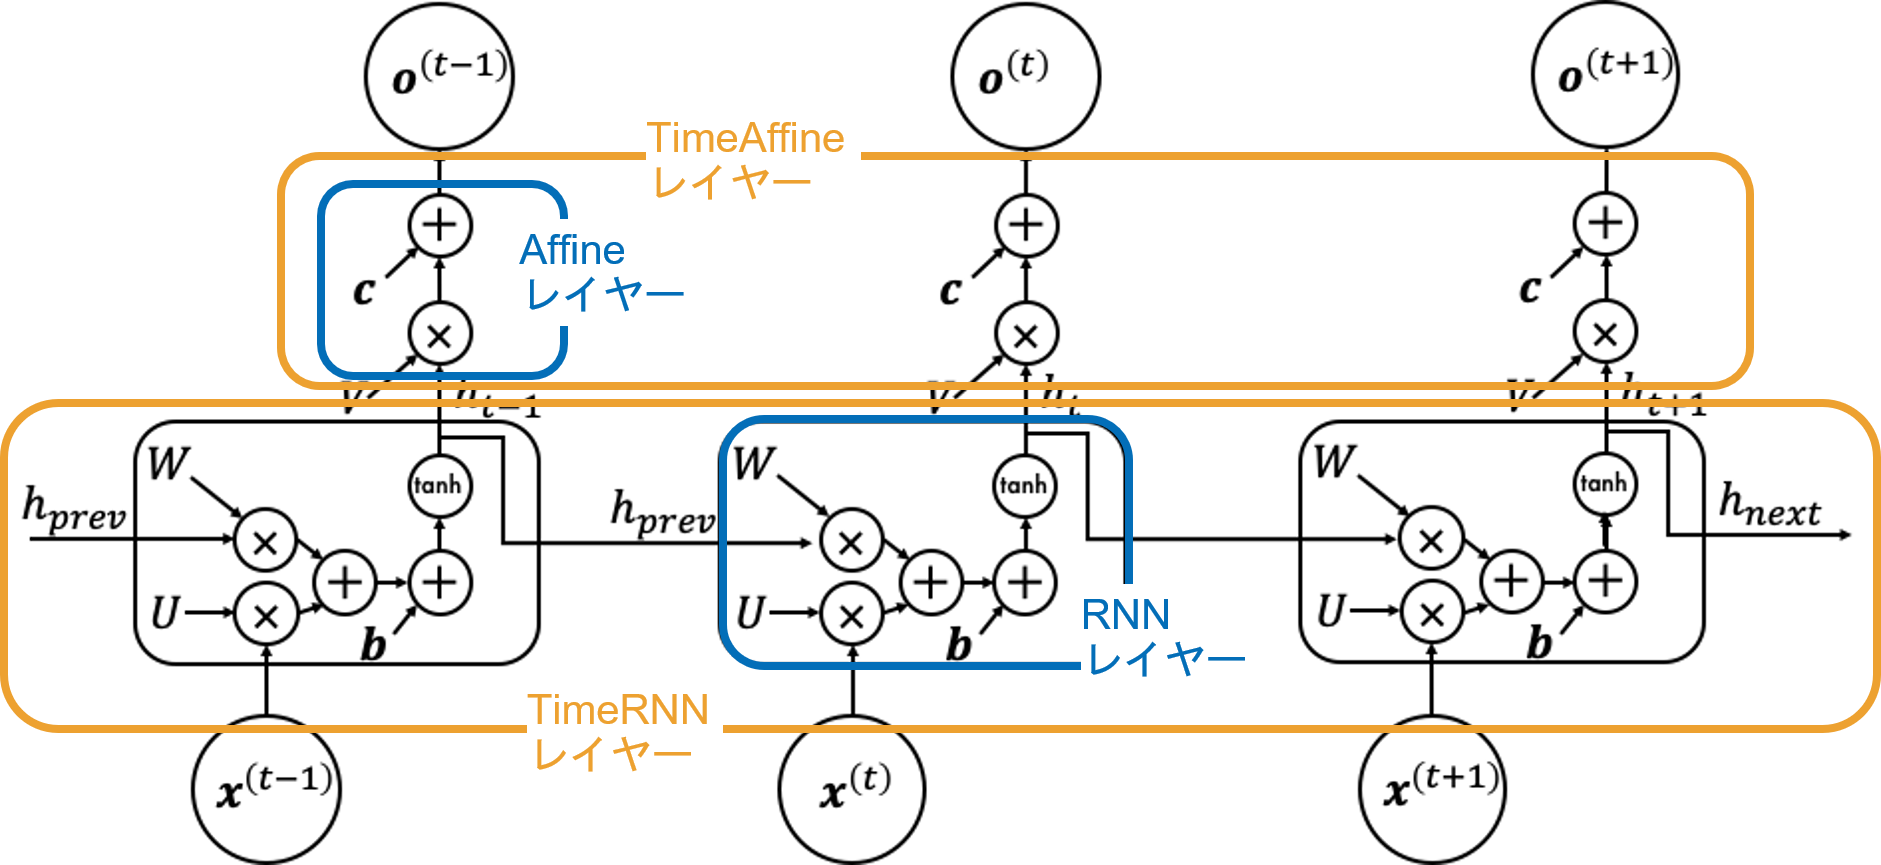

### TimeEmbedding クラス

TimeEmbedding クラスの入力として想定する形式は（バッチサイズ：N）×（単語数：T）です。<br>

バッチサイズは一度に処理する系列データの数、単語数は1つの系列データを構成する単語の数を指す。言語データは単語が時刻に沿って流れていくと解釈するため、単語数はそのまま時刻数と考えます。

そしてEmbed層で各単語をD次元ベクトルに変換する場合の出力は（バッチサイズ：N）×（単語数=時刻数：T）×（次元数：D）となります。

系列に発展させた形としては、順伝播/逆伝播ともに時刻数 $t$ をfor文で順に処理してやれば良いです。

In [20]:
# TimeEmbeddingクラス
class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W

    def forward(self, xs):
        N, T = xs.shape   ### 系列データの形状
        V, D = self.W.shape ### 単語ベクトルを並べた行列Wの形状
        out = np.empty((N, T, D), dtype='f') ### 出力データの形状
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W) ### Embed層を用意
            out[:, t, :] = layer.forward(xs[:, t]) ### 系列データの時刻tに対応する単語IDを取得し、Embed層でベクトルに変換
            self.layers.append(layer)
        return out

    def backward(self, dout):
        N, T, D = dout.shape
        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]
        self.grads[0][...] = grad
        return None

### TimeAffine クラス
TimeAffineクラスの入力として想定する形式は（バッチサイズ）×（単語数=時刻数）×（単語ベクトル次元数）です。<br>

このAffineクラスによって単語ベクトル次元数$D_1$から$D_2$に変換すると考えれば、サイズ$D_1 \times D_2$ の重み行列を用意すればよいです。

すると出力は（バッチサイズ）×（単語数=時刻数）×（$D_2$）となります。

In [21]:
# TimeAffineクラス
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params
        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params
        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)
        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)
        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx

### TimeSoftmaxWithLoss クラス
TimeSoftmaxWithLoss クラスの入力として想定する形式は（バッチサイズ）×（単語数=時刻数）×（次元数）であり、この次元数についてsoftmax関数により変換を行うものと考える。


In [22]:
# TimeSoftmaxWithLossクラス
class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None

    def forward(self, xs, ts):
        N, T, V = xs.shape
        if ts.ndim == 3:  # 教師ラベルがone-hotベクトルの場合
            ts = ts.argmax(axis=2)
        # バッチ分と時系列分をまとめる（reshape）
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        loss = -np.sum(ls)
        loss /= len(ts)
        self.cache = (ts, ys, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, (N, T, V) = self.cache
        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= len(ys)
        dx = dx.reshape((N, T, V))
        return dx

## ネットワーク定義
### RNNクラス
RNNクラスは以下に従って定義する。
    
  - `Wx`, `Wh`はそれぞれ順伝播時に入力ベクトル**x**、前時刻の隠れ層ベクトル**`h_next`**にかかる重み行列を指す
  - bは順伝播の計算に使用するバイアス項とする
  - 活性化関数は `tanh`とする

#### RNNクラス
* <font color="Red">問2. RNNクラスを完成させる</font><br>
    * <font color="Red">問2-1. 【forward関数】b, Wh, h_prev, Wx, xの5つの変数を使って、内部状態 t を計算する式を記述してください。</font><br>
    * <font color="Red">問2-2. 【backward関数】Wh, Wx について、逆伝播に使う勾配 dWh,dWx を算出する式を記述してください。</font><br>

【ヒント】
- 問2-1：第6章「RNN」の「順伝播」のセッションの数式を参照しましょう
- 問2-2：第6章「RNN」の「逆伝播」のセッションの数式を参照しましょう

In [23]:
# RNNクラス
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params 
        t = np.dot(x, Wx) + np.dot(h_prev, Wh) + b### 問2-1 ###
        h_next = np.tanh(t) 
        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        dt = dh_next * (1 - h_next ** 2) 
        db = np.sum(dt, axis=0) 
        dWh = np.dot(h_prev.T, dt)### 問2-2 ###
        dh_prev = np.dot(dt, Wh.T) 
        dWx = np.dot(x.T, dt)### 問2-3 ###
        dx = np.dot(dt, Wx.T) 
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        return dx, dh_prev

#### TimeRNNクラス

TimeRNNクラスの仕様は以下の通り。
  
  1. 順伝播
      - 時刻`t`を時系列分だけfor文でループさせる。
      - 順伝播により計算した隠れ層をメンバ変数`h`として格納する。
      - 順伝播時にはメンバ変数`h`と入力データのうち時刻`t`に対応するデータを使用して出力を計算する。
      
      
  2. 逆伝播
      - 今回のタスクにおいては、全時刻において次単語を予測し、その予測について損失が計算される、即ち勾配が入力されてくるため、逆伝播の入力`dhs`の想定される形は（バッチサイズ）×（単語数=時刻数）×（RNNの出力次元数）となる。
      - 各時刻において、次の時刻から伝播してきた勾配と現時刻における出力から伝播してきた勾配との和を入力としてRNN層の逆伝播を計算する。


【補足：Truncated BPTT】<br>

- 今回のタスクにおける目的はRNNネットワークが正しく実装できていることだ。簡単に学習が成功していることを確認するため、（実務でも用いられる）Truncated BPTT という少々特殊な処理を行う。
    
- 今回のタスクでは、入力する単語数（時刻数）として1000程度を入力しているが、この単語全てを順伝播させて逆伝播を計算し、パラメータ更新を1度行うのは効率が悪い。そのため、順伝播は1000単語で行うものの逆伝播を5単語程度で区切って行う Truncated BPTT という方式を取る。
    
  1. stateful
    
      1. まず、連続する5単語（例えば1~5番）を入力として順伝播・逆伝播・パラメータ更新を行う。
      1. その際、順伝播の最終時刻における隠れ層`h`の値をメンバ変数として保持しておく。
      1. 次に5単語（先の例では6~10番）を入力として順伝播・逆伝播・パラメータ更新を行うが、その際に初期入力の`h`を0で初期化せず、前から保持しているメンバ変数`h`の値をそのまま使用する。
      1. このことにより、逆伝播は5単語単位で行われるが、順伝播は最初の単語から順にずっと計算されてきた値を使用することができる。
      1. `stateful`がTrueの際にこのメンバ変数`h`の保持を行う。Falseの場合には`forward`関数が呼ばれるたびに`h`がリセット、即ち0で初期化される。
    
  1. set_state
    - 内部状態`h`を外から設定するための関数。
  
  1. reset_state
    - 内部状態`h`を外から削除するための関数。
  
  1. params や grads としてパラメータ・勾配をまとめる
    - 後でネットワーククラスを定義した際に、パラメータ更新などを楽に実行するための処理。
  
  1. backward における入力dhsの次元数による場合分け
    - 今回のタスクでは全時刻において勾配が逆伝播するため、`dhs`の想定される形は（バッチサイズN）×（単語数=時刻数T）×（RNNの出力次元数H）となるが、この後別のタスクを解く際には、全時刻ではなく最終時刻の出力のみから勾配が伝播する。<br>
    - この場合、dhsの次元数が違うため三次元に拡張することが必要になる。<br>
    - 最終時刻の出力のみから伝播してきたdhs の形は`(N,T,D)`のうち、`(N,D)`となっている。<br>
    - 最終時刻以外の勾配については何も伝播してきていないことから、全て0とすることで問題なく計算がなされる。<br>
    - 以上のことから、まず`np.zeros((N,T,D))`によって勾配の形を整え、その勾配の`[:,-1,:]`に対して入力された最終時刻における勾配を代入することで変わらず逆伝播を行うことができる。<br>

* <font color="Red">問3. TimeRNNクラスを完成させる</font><br>
    * <font color="Red">問3-1. 【forward関数】RNNクラスのforward関数を用いて、系列データxsと隠れ状態ベクトルhから時刻tの中間層の出力を算出しましょう。</font><br>
    * <font color="Red">問3-2. 【backward関数】RNNクラスのbackward関数を用いて、勾配dx, dhを算出しましょう。</font><br>

In [24]:
# TimeRNNクラス
class TimeRNN:
    def __init__(self,input_size, output_size, stateful=False):
        D, H = input_size, output_size
        rn = np.random.randn
        np.random.seed(0)
        Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        b = np.zeros(H).astype('f')
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.dh = None, None
        self.stateful = stateful
        self.input_shapes = None

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape
        self.input_shapes = [N,T,D]
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)### 問3-1 ###
            hs[:, t, :] = self.h
            self.layers.append(layer)
        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, D = self.input_shapes
        D, H = Wx.shape      
        if dhs.ndim == 2:
            temp = np.zeros((N,T,H))
            temp[:,-1,:] = dhs
            dhs = temp
        N, T, H = dhs.shape
        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)### 問3-2 ###
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None

### SimpleRNNClassifier クラス
バッチサイズN、単語数T、単語の種類数V、embedにより単語をベクトル化した際の次元数D、RNNによる出力次元数Hとする。

入力されてくるデータのサイズは`(N,T)`であり、TimeEmbedding層により`(N,T,D)`に変換される。<br>

データはさらにTimeRNN層により`(N,T,H)`に変換され、TimeAffine層により`(N,T,V)`に変換された後、V次元の中で最大のものを予測単語IDとして出力する。<br>

損失については、Sigmoidを使用してV種類の各単語について確率値を出力し、クロスエントロピーで計算する。

* <font color="Red">問4. loss_layerとrnn_layerに当てはまるクラスを記述して、モデルを完成させよう。</font><br>
* 【補足】statefulの初期値はFalseとする

In [25]:
# SimpleRNNClassifierクラス
class SimpleRNNClassifier:
    def __init__(self, wordvec_size, hidden_size):
        D, H = wordvec_size, hidden_size
        rn = np.random.randn
        np.random.seed(0)

        # 重みの初期化
        affine_W = (rn(H, 1) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(1).astype('f')

        # レイヤの生成
        self.affine_layer = Affine(affine_W, affine_b)
        self.loss_layer = SigmoidWithLoss()### 問4-1 ###
        self.rnn_layer = TimeRNN(D, H, stateful=False)### 問4-2 ###
# TimeRNN(rn_Wx, rn_Wh, rn_b, stateful=False)
        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        self.params += self.rnn_layer.params
        self.grads += self.rnn_layer.grads
        self.params += self.affine_layer.params
        self.grads += self.affine_layer.grads

    def forward(self, xs, ts):
        xs = self.predict(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def predict(self, xs):
        xs = self.rnn_layer.forward(xs)[:,-1,:]
        xs = self.affine_layer.forward(xs)
        return xs

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        dout = self.affine_layer.backward(dout)
        dout = self.rnn_layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

### 学習・評価

optimizerにはAdamを使用する。その他の設定は以下の通り。<br>
- 学習率(lr)：0.01<br>
- epoch数(n_epoch)：10<br>
- 単語ベクトルの次元(wordvec_size)：25<br>
- 隠れ層の次元(hidden_size)：100<br>
- バッチサイズ(batch_size)：100<br>

各エポックに対し、データを500個、つまりバッチサイズ5個分学習させるごとに損失を計算して表示するように設定する。

In [26]:
lr = 0.01
n_epoch = 10
eval_interval = 5
wordvec_size = 25
hidden_size = 100
optimizer = Adam(lr)
batch_size = 100
rnn_loss_list = []
rnn_model = SimpleRNNClassifier(wordvec_size, hidden_size)

np.random.seed(0)
for epoch in range(n_epoch):
    total_rnn_loss = 0
    perm = np.random.permutation(len(X_train))
    for i, idx in enumerate(range(0, len(X_train), batch_size)):
        X_batch = X_train[perm[idx:idx+batch_size]]
        T_batch = T_train[perm[idx:idx+batch_size]]
        
        rnn_loss = rnn_model.forward(X_batch, T_batch)
        rnn_model.backward()
        optimizer.update(rnn_model.params, rnn_model.grads)
        total_rnn_loss += rnn_loss*len(X_batch)
        if i % eval_interval == 0:
            print('| idx %d / %d | RNN loss %.2f'
                 %(idx, len(X_train), total_rnn_loss/(idx+batch_size)))
    average_rnn_loss = total_rnn_loss / len(X_train)
    rnn_loss_list.append(average_rnn_loss)
    rnn_pred = rnn_model.predict(X_test).flatten()
    print('| epoch %d | RNN loss %.2f'
          % (epoch+1, average_rnn_loss))

| idx 0 / 1500 | RNN loss 0.79
| idx 500 / 1500 | RNN loss 0.81
| idx 1000 / 1500 | RNN loss 0.78
| epoch 1 | RNN loss 0.76
| idx 0 / 1500 | RNN loss 0.68
| idx 500 / 1500 | RNN loss 0.70
| idx 1000 / 1500 | RNN loss 0.70
| epoch 2 | RNN loss 0.69
| idx 0 / 1500 | RNN loss 0.68
| idx 500 / 1500 | RNN loss 0.69
| idx 1000 / 1500 | RNN loss 0.69
| epoch 3 | RNN loss 0.69
| idx 0 / 1500 | RNN loss 0.68
| idx 500 / 1500 | RNN loss 0.66
| idx 1000 / 1500 | RNN loss 0.66
| epoch 4 | RNN loss 0.67
| idx 0 / 1500 | RNN loss 0.71
| idx 500 / 1500 | RNN loss 0.68
| idx 1000 / 1500 | RNN loss 0.69
| epoch 5 | RNN loss 0.69
| idx 0 / 1500 | RNN loss 0.67
| idx 500 / 1500 | RNN loss 0.68
| idx 1000 / 1500 | RNN loss 0.68
| epoch 6 | RNN loss 0.67
| idx 0 / 1500 | RNN loss 0.67
| idx 500 / 1500 | RNN loss 0.64
| idx 1000 / 1500 | RNN loss 0.65
| epoch 7 | RNN loss 0.65
| idx 0 / 1500 | RNN loss 0.67
| idx 500 / 1500 | RNN loss 0.64
| idx 1000 / 1500 | RNN loss 0.65
| epoch 8 | RNN loss 0.64
| idx 0 

これで学習完了だ。lossが0.7以下になっていれば正常に学習できたと言える。

## LSTMによるpos/neg分類（スクラッチ）

次に、RNNの派生モデルであるLSTMモデルで同じようにpos/negを学習させてみよう。

LSTMクラスの仕様はRNNクラスとほとんど同様だ。<br>
各ゲートの計算と通常の順伝播の計算に使用するパラメータを行列にまとめ、一行で計算できるように実装している。<br>
なおf,g,i,o はそれぞれ、忘却ゲート・入力からの順伝播・入力ゲート・出力ゲートを表している。


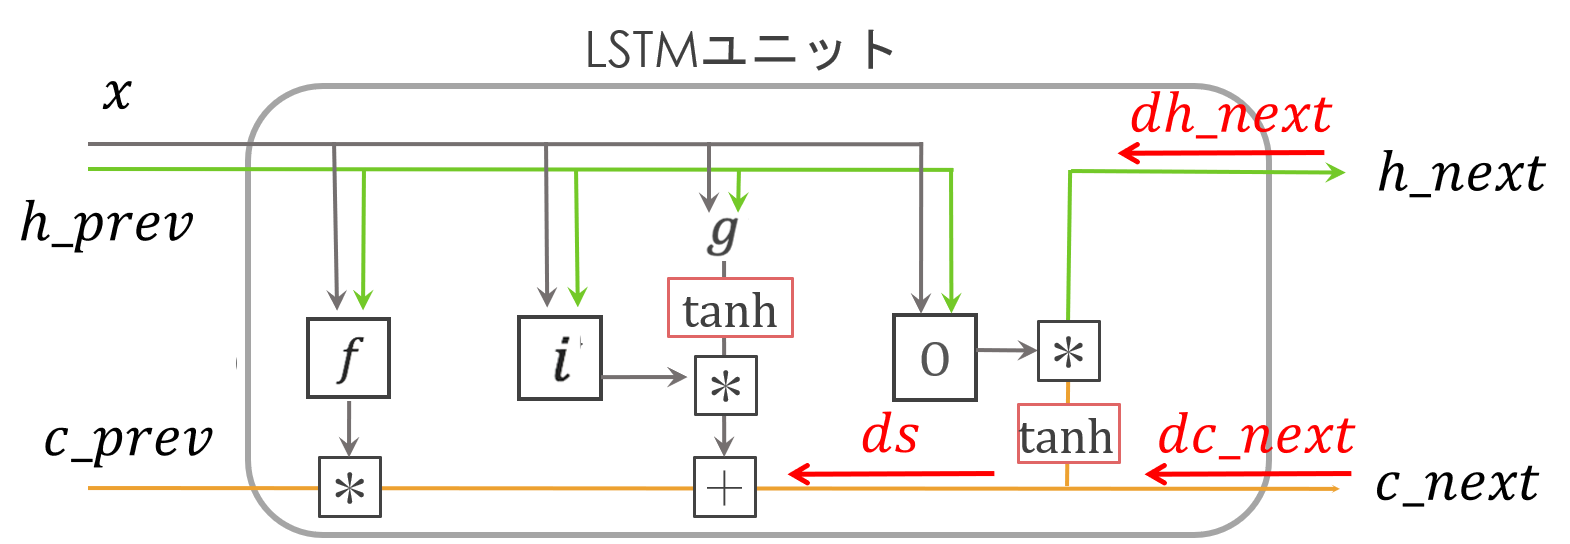

#### LSTMクラス
* <font color="Red">問5-1. 【forward関数】忘却ゲート、 入力からの順伝播、 入力ゲートの値f,g,iと更新前の記憶セルの値c_prevを利用して、更新後の記憶セルの値 **c_next** の算出式を記述しよう</font><br>
* <font color="Red">問5-2. 【forward関数】出力ゲートの値oと更新後の記憶セルの値c_nextを利用して、次の時刻に受け渡す出力値 **h_next** の算出式を記述しよう</font><br>
* <font color="Red">問5-3. 【backward関数】上の図を参考に、dc_nextとdh_next、出力ゲートの値o、および tanh_c_next ( = np.tanh(c_next) )の値を利用して、分岐する前の逆伝播 **ds** の算出式を記述しよう</font><br>
* 【補足】$\tanh(x)$ の微分は $1-\tanh(x)^2$ となる

In [27]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b 
        f,g,i,o = A[:, :H],A[:, H:2*H],A[:, 2*H:3*H],A[:, 3*H:]
        f,g,i,o = sigmoid(f),np.tanh(g),sigmoid(i),sigmoid(o) 
        c_next = f * c_prev + g * i### 問5-1 ###
        h_next = o * np.tanh(c_next)### 問5-2 ###
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache
        tanh_c_next = np.tanh(c_next)
        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)### 問5-3 ###
        dc_prev = ds * f 
        di,df,do,dg = ds * g, ds * c_prev, dh_next * tanh_c_next, ds * i
        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)
        dA = np.hstack((df, dg, di, do))
        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)
        return dx, dh_prev, dc_prev

#### TimeLSTMクラス

これもTimeRNNと同じように実装するが、SimpleRNN のときと違い、重みの初期化に注意を払う必要がある。

LSTMでは最初に1ステップの処理をLSTMクラスとして実装し、Tステップ分まとめて処理するクラスをTimeLSTMとして実装する。ここで注目したいのがf, g, i, oの4つのアフィン変換だ。

LSTMでは4つの式により個別に計算しているが、TimeLSTMでは高速化のために、ひとつの式でまとめて計算することで高速化するという工夫をしている。結論としてアフィン変換を1回の計算で済ませるため、4つの重みをひとつにまとめる必要がある。

そこでWx, Whの式における重みHを事前に4倍しておこう。

* <font color="Red">問6. 【initクラス】上記の説明に沿って、Wx,Wh,bのrn(・)およびnp.zeros(・)の中身をそれぞれ書き直そう。</font><br>
  * <font color="Red">問6-1. Wxのrn(・)の中身を記述してください。</font><br>
  * <font color="Red">問6-2. Whのrn(・)の中身を記述してください。</font><br>
  * <font color="Red">問6-3. bのrn(・)の中身を記述してください。</font><br>

In [28]:
class TimeLSTM:
    def __init__(self, input_size, output_size, stateful=False):
        D,H = input_size, output_size
        rn = np.random.randn
        np.random.seed(0)        
        Wx = (rn(D, 4*H) / np.sqrt(D)).astype('f')### 問6-1 ###
        Wh = (rn(H, 4*H)/np.sqrt(H)).astype('f')### 問6-2 ###
        b = np.zeros(4*H).astype('f')### 問6-3 ###
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
        self.input_shapes = None

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]
        self.input_shapes = [N,T,D]
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')
        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c) 
            hs[:, t, :] = self.h
            self.layers.append(layer)
        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        H = Wh.shape[0]
        N, T, D = self.input_shapes
        if dhs.ndim == 2:
            temp = np.zeros((N,T,H))
            temp[:,-1,:] = dhs
            dhs = temp
        N, T, H = dhs.shape
        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc) 
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c
    def reset_state(self):
        self.h, self.c = None, None

### LSTMClassifier クラス
バッチサイズ：N、単語数：T、単語の種類数：V、embedにより単語をベクトル化した際の次元数：D、LSTMによる出力次元数：Hとする。

あとはRNNの場合と同様にネットワークを組めばよい。<br>


In [29]:
# LSTMClassifierクラス
class LSTMClassifier:
    def __init__(self, wordvec_size, hidden_size):
        D, H = wordvec_size, hidden_size
        rn = np.random.randn
        np.random.seed(0)

        # 重みの初期化
        affine_W = (rn(H, 1) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(1).astype('f')

        # レイヤの生成
        self.affine_layer = Affine(affine_W, affine_b)
        self.loss_layer = SigmoidWithLoss()
        self.rnn_layer = TimeLSTM(D, H, stateful=False)

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        self.params += self.rnn_layer.params
        self.grads += self.rnn_layer.grads
        self.params += self.affine_layer.params
        self.grads += self.affine_layer.grads

    def forward(self, xs, ts):
        xs = self.predict(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def predict(self, xs):
        xs = self.rnn_layer.forward(xs)[:,-1,:]
        xs = self.affine_layer.forward(xs)
        return xs

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        dout = self.affine_layer.backward(dout)
        dout = self.rnn_layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

### 学習，評価

RNNの場合と同じ設定で学習させてみよう。<br>
lossがRNNに比べて圧倒的に減少しているはずだ。

In [30]:
lr = 0.01
n_epoch = 10
eval_interval = 5
wordvec_size = 25
hidden_size = 100
optimizer = Adam(lr)
batch_size = 100
lstm_loss_list = []
lstm_model = LSTMClassifier(wordvec_size, hidden_size)

np.random.seed(0)
for epoch in range(n_epoch):
    total_lstm_loss = 0
    perm = np.random.permutation(len(X_train))
    for i, idx in enumerate(range(0, len(X_train), batch_size)):
        X_batch = X_train[perm[idx:idx+batch_size]]
        T_batch = T_train[perm[idx:idx+batch_size]]
        
        lstm_loss = lstm_model.forward(X_batch, T_batch)
        lstm_model.backward()
        optimizer.update(lstm_model.params, lstm_model.grads)
        total_lstm_loss += lstm_loss*len(X_batch)
        if i % eval_interval == 0:
            print('| idx %d / %d | LSTM loss %.2f |'
                 %(idx, len(X_train), total_lstm_loss/(idx+batch_size)))
    average_lstm_loss = total_lstm_loss / len(X_train)
    lstm_loss_list.append(average_lstm_loss)
    lstm_pred = lstm_model.predict(X_test).flatten()
    print('| epoch %d | LSTM loss %.2f'
          % (epoch+1, average_lstm_loss))

| idx 0 / 1500 | LSTM loss 0.70 |
| idx 500 / 1500 | LSTM loss 0.73 |
| idx 1000 / 1500 | LSTM loss 0.72 |
| epoch 1 | LSTM loss 0.71
| idx 0 / 1500 | LSTM loss 0.68 |
| idx 500 / 1500 | LSTM loss 0.68 |
| idx 1000 / 1500 | LSTM loss 0.68 |
| epoch 2 | LSTM loss 0.68
| idx 0 / 1500 | LSTM loss 0.67 |
| idx 500 / 1500 | LSTM loss 0.68 |
| idx 1000 / 1500 | LSTM loss 0.67 |
| epoch 3 | LSTM loss 0.67
| idx 0 / 1500 | LSTM loss 0.67 |
| idx 500 / 1500 | LSTM loss 0.64 |
| idx 1000 / 1500 | LSTM loss 0.65 |
| epoch 4 | LSTM loss 0.65
| idx 0 / 1500 | LSTM loss 0.65 |
| idx 500 / 1500 | LSTM loss 0.61 |
| idx 1000 / 1500 | LSTM loss 0.60 |
| epoch 5 | LSTM loss 0.60
| idx 0 / 1500 | LSTM loss 0.53 |
| idx 500 / 1500 | LSTM loss 0.52 |
| idx 1000 / 1500 | LSTM loss 0.50 |
| epoch 6 | LSTM loss 0.51
| idx 0 / 1500 | LSTM loss 0.44 |
| idx 500 / 1500 | LSTM loss 0.39 |
| idx 1000 / 1500 | LSTM loss 0.38 |
| epoch 7 | LSTM loss 0.38
| idx 0 / 1500 | LSTM loss 0.35 |
| idx 500 / 1500 | LSTM loss

## GRUによるpos/neg分類（スクラッチ）

GRUクラスの仕様はLSTMクラスとほとんど同じである。

各ゲートの計算と通常の順伝播の計算に使用するパラメータを行列にまとめ、一行で計算できるように実装している。なお r がリセットゲート、z が更新ゲートを表す。

#### GRUクラス
* <font color="Red">問7-1. 【forward関数】現在の状態値h_hatと過去の状態値h_prevを用いて、更新後の状態値 **h_next** を算出しよう</font><br>
* <font color="Red">問7-2. 【backward関数】LSTMの場合を参考に、$W_h$の逆伝播**$dW_h$**の計算式を実装しよう</font><br>
【補足】更新割合を表すパラメータ $r$ による補正が入る点に注意。

In [31]:
# GRUクラス
class GRU:
    def __init__(self, Wx, Wh):
        self.params = [Wx, Wh]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh = self.params
        H, H3 = Wh.shape
        Wxz, Wxr, Wx = Wx[:, :H], Wx[:, H:2 * H], Wx[:, 2 * H:]
        Whz, Whr, Wh = Wh[:, :H], Wh[:, H:2 * H], Wh[:, 2 * H:]

        z = sigmoid(np.dot(x, Wxz) + np.dot(h_prev, Whz))
        r = sigmoid(np.dot(x, Wxr) + np.dot(h_prev, Whr))
        h_hat = np.tanh(np.dot(x, Wx) + np.dot(r*h_prev, Wh))
        h_next = (1-z) * h_prev + z * h_hat### 問7-1 ###

        self.cache = (x, h_prev, z, r, h_hat)

        return h_next


    def backward(self, dh_next):
        Wx, Wh = self.params
        H, H3 = Wh.shape
        Wxz, Wxr, Wx = Wx[:, :H], Wx[:, H:2 * H], Wx[:, 2 * H:]
        Whz, Whr, Wh = Wh[:, :H], Wh[:, H:2 * H], Wh[:, 2 * H:]
        x, h_prev, z, r, h_hat = self.cache

        dh_hat =dh_next * z
        dh_prev = dh_next * (1-z)

        dt = dh_hat * (1 - h_hat ** 2)
        dWh = np.dot((r * h_prev).T, dt)### 問7-2 ###
        dhr = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)
        dh_prev += r * dhr

        dz = dh_next * h_hat - dh_next * h_prev
        dt = dz * z * (1-z)
        dWhz = np.dot(h_prev.T, dt)
        dh_prev += np.dot(dt, Whz.T)
        dWxz = np.dot(x.T, dt)
        dx += np.dot(dt, Wxz.T)

        dr = dhr * h_prev
        dt = dr * r * (1-r)
        dWhr = np.dot(h_prev.T, dt)
        dh_prev += np.dot(dt, Whr.T)
        dWxr = np.dot(x.T, dt)
        dx += np.dot(dt, Wxr.T)

        dWx = np.hstack((dWxz, dWxr, dWx))
        dWh = np.hstack((dWhz, dWhr, dWh))
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh


        return dx, dh_prev

#### TimeGRUクラス
TimeGRUクラスの仕様はTimeLSTMクラスとほとんど同じである。


* <font color="Red">問8. 【initクラス】上記の説明に沿って、Wx,Whのrn(・)の中身をそれぞれ書き直そう。</font><br>
  * <font color="Red">問8-1. Wxのrn(・)の中身を記述してください。</font><br>
  * <font color="Red">問8-2. Whのrn(・)の中身を記述してください。</font><br>
【補足】LSTMとはアフィン変換の数が異なるため、重みの倍率が変化していることに注意。

In [32]:
# TimeGRUクラス
class TimeGRU:
    def __init__(self, input_size, output_size, stateful=False):
        D, H = input_size, output_size
        rn = np.random.randn
        np.random.seed(0)
        
        Wx = (rn(D, 3*H) / np.sqrt(D)).astype('f')### 問8-1 ###
        Wh = (rn(H, 3*H)/np.sqrt(H)).astype('f')### 問8-2 ###

        self.params = [Wx, Wh]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh)]
        self.layers = None
        self.h = None
        self.stateful = stateful
        self.input_shapes = None

    def forward(self, xs):
        Wx, Wh = self.params
        N, T, D = xs.shape
        H, H3 = Wh.shape
        self.input_shapes = [N, T, D]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
            
        for t in range(T):
            layer = GRU(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)
        return hs

    def backward(self, dhs):
        Wx, Wh = self.params
        D = Wx.shape[0]
        H = Wh.shape[0]
        N, T, D = self.input_shapes
        
        if dhs.ndim == 2:
            temp = np.zeros((N,T,H))
            temp[:,-1,:] = dhs
            dhs = temp
        N, T, H = dhs.shape
        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)

            dxs[:, t, :] = dx
            
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None

### GRUClassifierクラス

あとはLSTMと同様、各種パーツを組み上げてモデルを構築する。

In [33]:
# GRUClassifierクラス
class GRUClassifier:
    def __init__(self, wordvec_size, hidden_size):
        D, H = wordvec_size, hidden_size
        rn = np.random.randn
        np.random.seed(0)

        # 重みの初期化
        affine_W = (rn(H, 1) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(1).astype('f')

        # レイヤの生成
        self.affine_layer = Affine(affine_W, affine_b)
        self.loss_layer = SigmoidWithLoss()
        self.gru_layer = TimeGRU(D, H, stateful=False)

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        self.params += self.gru_layer.params
        self.grads += self.gru_layer.grads
        self.params += self.affine_layer.params
        self.grads += self.affine_layer.grads

    def forward(self, xs, ts):
        xs = self.predict(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def predict(self, xs):
        xs = self.gru_layer.forward(xs)[:,-1,:]
        xs = self.affine_layer.forward(xs)
        return xs

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        dout = self.affine_layer.backward(dout)
        dout = self.gru_layer.backward(dout)
        return dout

    def reset_state(self):
        self.gru_layer.reset_state()

### 学習，評価

こちらもRNN,LSTMと同じ設定で学習・評価する。
lossはLSTM並みになっていればOKだ。

In [34]:
lr = 0.01
n_epoch = 10
eval_interval = 5
wordvec_size = 25
hidden_size = 100
optimizer = Adam(lr)
batch_size = 100
gru_loss_list = []
gru_model = GRUClassifier(wordvec_size, hidden_size)

np.random.seed(0)
for epoch in range(n_epoch):
    total_gru_loss = 0
    perm = np.random.permutation(len(X_train))
    for i, idx in enumerate(range(0, len(X_train), batch_size)):
        X_batch = X_train[perm[idx:idx+batch_size]]
        T_batch = T_train[perm[idx:idx+batch_size]]
        
        gru_loss = gru_model.forward(X_batch, T_batch)
        gru_model.backward()
        optimizer.update(gru_model.params, gru_model.grads)
        total_gru_loss += gru_loss*len(X_batch)
        if i % eval_interval == 0:
            print('| idx %d / %d | RNN loss %.2f'
                 %(idx, len(X_train), total_gru_loss/(idx+batch_size)))
    average_gru_loss = total_gru_loss / len(X_train)
    gru_loss_list.append(average_gru_loss)
    gru_pred = gru_model.predict(X_test).flatten()
    print('| epoch %d | GRU loss %.2f'
          % (epoch+1, average_gru_loss))

| idx 0 / 1500 | RNN loss 0.69
| idx 500 / 1500 | RNN loss 0.80
| idx 1000 / 1500 | RNN loss 0.76
| epoch 1 | GRU loss 0.75
| idx 0 / 1500 | RNN loss 0.68
| idx 500 / 1500 | RNN loss 0.68
| idx 1000 / 1500 | RNN loss 0.68
| epoch 2 | GRU loss 0.68
| idx 0 / 1500 | RNN loss 0.66
| idx 500 / 1500 | RNN loss 0.67
| idx 1000 / 1500 | RNN loss 0.66
| epoch 3 | GRU loss 0.66
| idx 0 / 1500 | RNN loss 0.63
| idx 500 / 1500 | RNN loss 0.62
| idx 1000 / 1500 | RNN loss 0.62
| epoch 4 | GRU loss 0.62
| idx 0 / 1500 | RNN loss 0.62
| idx 500 / 1500 | RNN loss 0.56
| idx 1000 / 1500 | RNN loss 0.56
| epoch 5 | GRU loss 0.56
| idx 0 / 1500 | RNN loss 0.46
| idx 500 / 1500 | RNN loss 0.46
| idx 1000 / 1500 | RNN loss 0.44
| epoch 6 | GRU loss 0.45
| idx 0 / 1500 | RNN loss 0.28
| idx 500 / 1500 | RNN loss 0.31
| idx 1000 / 1500 | RNN loss 0.31
| epoch 7 | GRU loss 0.31
| idx 0 / 1500 | RNN loss 0.24
| idx 500 / 1500 | RNN loss 0.20
| idx 1000 / 1500 | RNN loss 0.18
| epoch 8 | GRU loss 0.19
| idx 0 

## モデルの比較

損失のグラフを可視化してモデルを比較する。<br>

単純なRNNよりもLSTM・GRUの方が明確に良いモデルであるという結果になった。

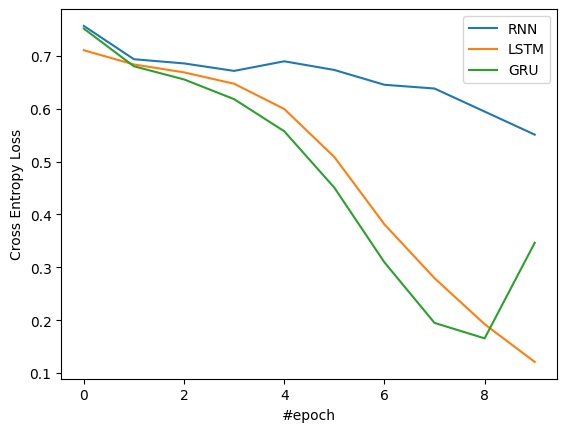

In [35]:
import matplotlib.pyplot as plt
plt.plot(range(n_epoch), rnn_loss_list)
plt.plot(range(n_epoch), lstm_loss_list)
plt.plot(range(n_epoch), gru_loss_list)
plt.legend(["RNN", "LSTM", "GRU"])
plt.xlabel("#epoch")
plt.ylabel("Cross Entropy Loss")
plt.show()

## 双方向LSTMによるpos/neg分類（TensorFlow） 
(<u>ライブラリを使用しtensorflow.keras.layers.Bidirectionalやtensorflow.keras.layers.LSTMは使用する</u>)



ここからはより発展したモデルである双方向RNN、その中でも特に双方向LSTMを扱う。

双方向LSTMは系列データを**過去から未来へ**読み込ませる順方向LSTMと、**未来から過去へ**読み込ませる逆方向LSTMの2つを組み合わせたモデルである。

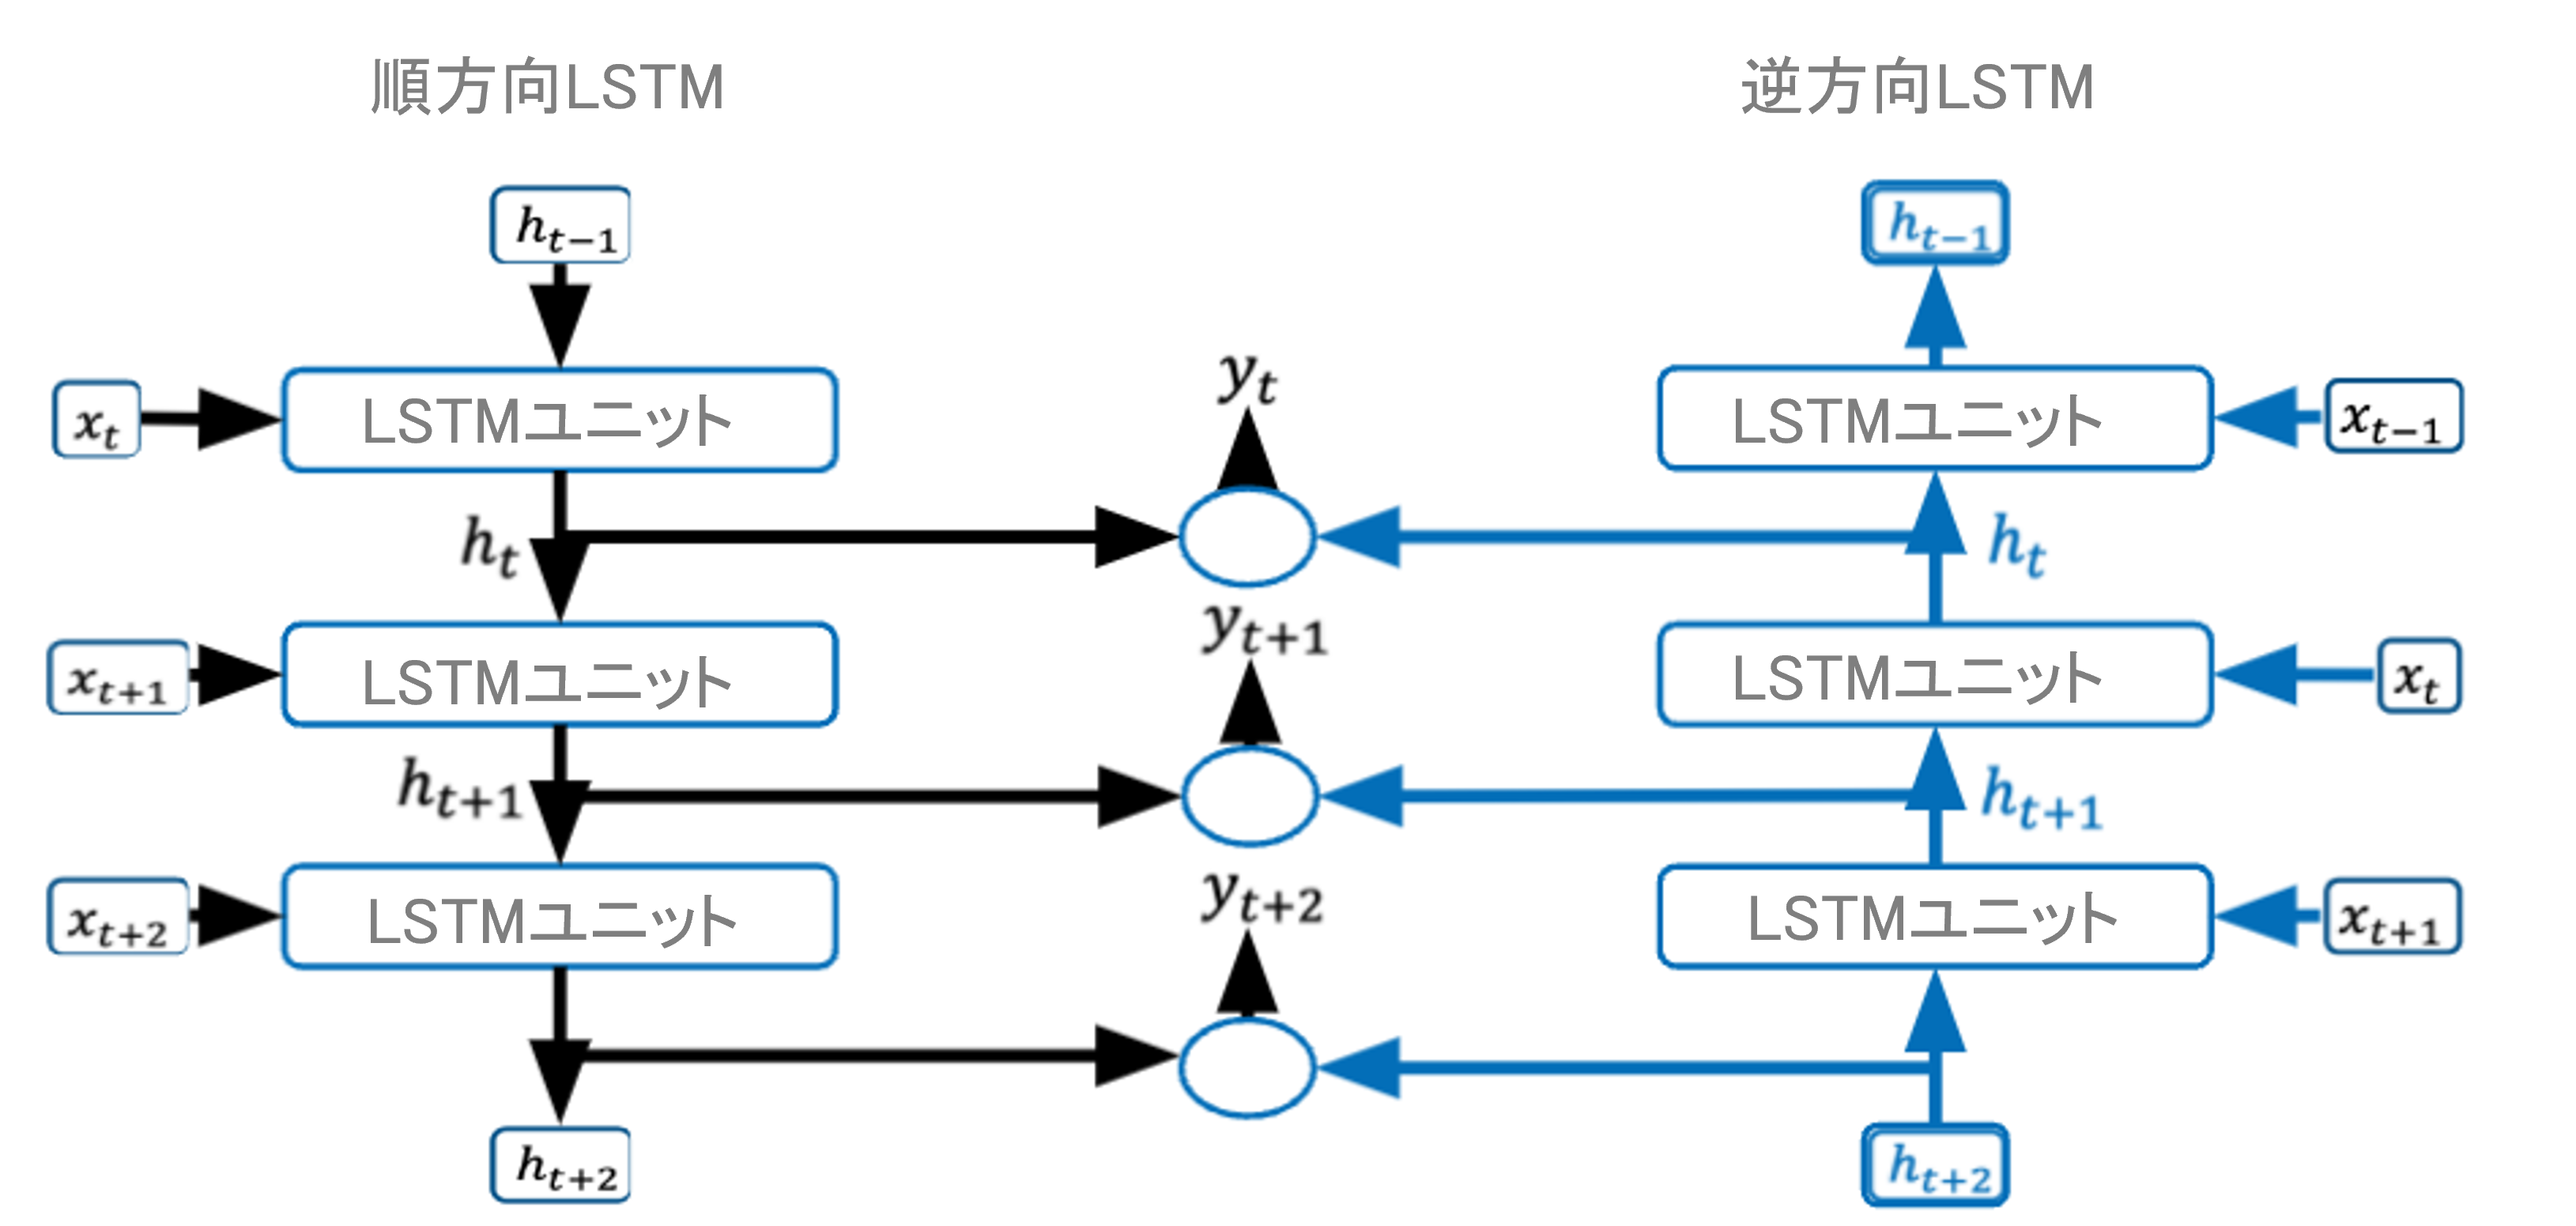

スクラッチで組むと冗長になってしまうため、TensorFlowを使って実装しよう。

In [59]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,  Bidirectional,LSTM
from tensorflow.keras import Model

In [60]:
batch_size = 100
n_epoch = 5
embedding = []
labels = []
for d in data:
    embedding.append(np.array([embed_one_word_via_model(word,model) for word in d["text"]]))
    labels.append(int(d["label"]))
embedding = np.array(embedding)
labels = np.array(labels)

X_train_1, X_test_1, T_train_1, T_test_1 = train_test_split(embedding, labels, random_state=0)
train_ds = tf.data.Dataset.from_tensor_slices((X_train_1, T_train_1)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test_1, T_test_1)).batch(batch_size)

T_train_1 = T_train_1[:, np.newaxis]
T_test_1 = T_test_1[:, np.newaxis]

In [61]:
print(len(labels))
print(len(embedding))

2000
2000


* <font color="Red">問9. Tensorflowを使って双方向LSTMクラスを完成させよう。</font><br>
    * <font color="Red">問9-1. 【イニシャライザ】双方向LSTMクラスのレイヤーを記述しよう。なお、下記コードの空欄(ア)(イ)(ウ)を埋めて入力すること。</font><br>
    ```Bidirectional(LSTM((ア),return_sequences=True,return_state=True),input_shape=((イ),(ウ)))```
    * <font color="Red">問9-2. 【出力層】出力としてpos/negの確率を算出するレイヤーを記述しよう</font><br>

In [83]:
# BiLSTMNetworkクラス
class BilstmModel(Model):
    def __init__(self, embedding_dim, hidden_dim):
        super(BilstmModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True, return_state=True), input_shape=(400, embedding_dim))###問9-1###
        self.dense = tf.keras.layers.Dense(1, activation='sigmoid')###問9-2###

    def call(self, x):
        _, h0,_,h1,_ = self.bi_lstm(x)
        h2 = tf.concat([h0, h1], 1)
        h2 = self.dense(h2)
        return h2

In [73]:
# 作業コード
in_features = 5
out_features = 6
bilstm = bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True, return_state=True), input_shape=(4, embedding_dim))

NameError: name 'self' is not defined

### 学習，評価

こちらも前項までと同様の設定で学習・評価する。

In [84]:
bilstm_model_tf1 = BilstmModel(25,100)
# loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
loss_object = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_accuracy = tf.keras.metrics.BinaryAccuracy()
test_accuracy = tf.keras.metrics.BinaryAccuracy()

train_loss = tf.keras.metrics.Mean(name='train_loss')
# train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
# test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

@tf.function
def train_step(x, labels):
    with tf.GradientTape() as tape:
        predictions = bilstm_model_tf1(x, training=True)
        loss = loss_object(labels, predictions)
        gradients = tape.gradient(loss, bilstm_model_tf1.trainable_variables)
        optimizer.apply_gradients(zip(gradients, bilstm_model_tf1.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

@tf.function
def test_step(x, labels):
    predictions = bilstm_model_tf1(x, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

loss_list = []
for epoch in range(n_epoch):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    for x, T in train_ds:
        train_step(x, T)

    for  x_1, T_1 in test_ds:
        test_step(x_1, T_1)

    print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
    )
    loss_list.append(train_loss.result())

Epoch 1, Loss: 0.697098970413208, Accuracy: 50.66667175292969, Test Loss: 0.6931301355361938, Test Accuracy: 51.79999923706055
Epoch 2, Loss: 0.6870184540748596, Accuracy: 53.80000305175781, Test Loss: 0.696670651435852, Test Accuracy: 53.40000534057617
Epoch 3, Loss: 0.6774531602859497, Accuracy: 57.26667785644531, Test Loss: 0.6917682886123657, Test Accuracy: 52.999996185302734
Epoch 4, Loss: 0.669408917427063, Accuracy: 58.66667175292969, Test Loss: 0.6857634782791138, Test Accuracy: 56.599998474121094
Epoch 5, Loss: 0.6669946312904358, Accuracy: 57.4666633605957, Test Loss: 0.7009690999984741, Test Accuracy: 52.19999694824219


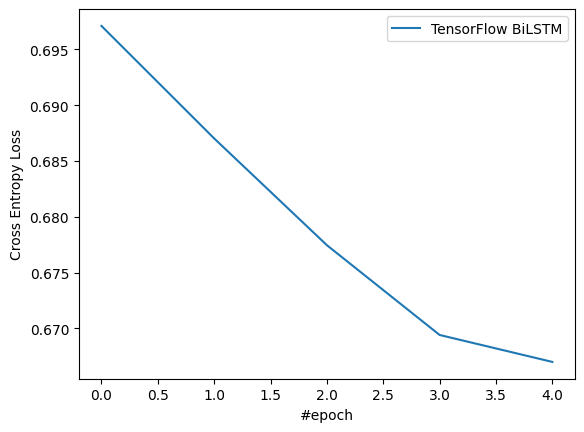

In [85]:
import matplotlib.pyplot as plt
plt.plot(range(n_epoch),loss_list)
plt.legend(["TensorFlow BiLSTM"])
plt.xlabel("#epoch")
plt.ylabel("Cross Entropy Loss")
plt.show()